<a href="https://colab.research.google.com/github/zuo-liangliang/fcn.berkeleyvision.org/blob/master/result_CNN-RNN-ATT_MSE_epoch250_batchsize64_lr0.001_88.39%25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 打印版本
import sys
import tensorflow as tf
import os

print("Python 版本:", sys.version)
print("TensorFlow 版本:", tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('No GPU found')
else:
    gpu_info = !nvidia-smi -L
    gpu_model = gpu_info[0].split(' ')[-1]
    print('GPU Model:', gpu_model)

os.chdir('/content/drive/MyDrive/SeptemberResult/result_RNNCAP_BCE_epoch30')
print(os.getcwd())

!pip install xlwt
!pip install matplotlib


In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


当前
GPU型号：Tesla T4
Driver版本：525.105.17
CUDA版本：12.0

In [ ]:
# !python RNNCAP_BCE_epoch30_batchsize16_lr0.001.py
# !python RNNCAP_BCE_epoch30_batchsize16_lr0.003.py
# !python RNNCAP_BCE_epoch30_batchsize16_lr0.005.py
!python RNNCAP_BCE_epoch30_batchsize16_lr0.007.py



In [5]:
# 定位到指定路径下
import os
# os.chdir('/content/drive/MyDrive/SeptemberResult/result_DNN_CCE_epoch250')
# os.chdir('/content/drive/MyDrive/SeptemberResult/result_CNN_MAE_epoch150')
# os.chdir('/content/drive/MyDrive/SeptemberResult/result_GRU_MAE_epoch100')

os.chdir('/content/drive/MyDrive/SeptemberResult/result_CNN-RNN-ATT_MSE_epoch250')

print(os.getcwd())


/content/drive/MyDrive/SeptemberResult/result_CNN-RNN-ATT_MSE_epoch250


No GPU available

Loaded dataset of 1120 samples, each sized (20, 15, 15, 1)


Train on 1008 samples
Test on 112 samples

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 name_model_input (InputLay  [(None, 20, 15, 15, 1)]      0         []                            
 er)                                                                                              
                                                                                                  
 time_distributed (TimeDist  (None, 20, 11, 11, 16)       416       ['name_model_input[0][0]']    
 ributed)                                                                                         
                                                                                                  
 time_distributed_1 (TimeDi  (None, 20, 5, 5, 16)         0         ['t

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 1s 24ms/step
[[27  0  2  1]
 [ 2 25  1  1]
 [ 0  1 29  3]
 [ 0  0  2 18]]
[[0.9  0.   0.07 0.03]
 [0.07 0.86 0.03 0.03]
 [0.   0.03 0.88 0.09]
 [0.   0.   0.1  0.9 ]]


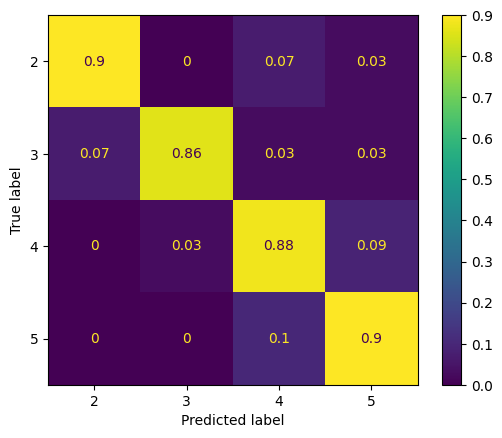

              precision    recall  f1-score   support

           2     0.9310    0.9000    0.9153        30
           3     0.9615    0.8621    0.9091        29
           4     0.8529    0.8788    0.8657        33
           5     0.7826    0.9000    0.8372        20

    accuracy                         0.8839       112
   macro avg     0.8820    0.8852    0.8818       112
weighted avg     0.8894    0.8839    0.8851       112

88.39%


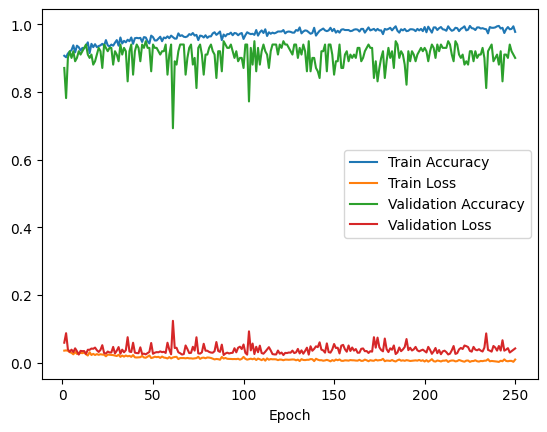

新的结果文件夹名称为： result_CNN-RNN-ATT_MSE_epoch250_batchsize64_lr0.001_88.39%
程序执行时间为：1114.78秒


In [6]:
# 7. result_CNN-RNN-ATT  CNN-GRU-Multiattention

# RNN部分是GRU
# 使用了Transformer的多头自注意力机制（Multi-Head Attention）和前馈神经网络（Feed-Forward Network）的模型
# 2层transformer

from keras.callbacks import Callback
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

from __future__ import print_function

import time
import os,sys
import numpy as np
import pandas as pd
import scipy.io as scio
import tensorflow as tf
tf.compat.v1.keras.backend.set_session
import keras
from keras.layers import Input, GRU, Dense, Flatten, Dropout, Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, TimeDistributed, LSTM
from keras.models import Model, load_model
import keras.backend as K
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Parameters
# use_existing_model = False  # 创建一个模型（False）默认创建一个新模型
use_existing_model = True    # 模型权重修改点 想要用已经存在的模型（True）
data_dir = '/content/drive/MyDrive/Colab_Notebooks/528BVP-acnt2/528[-1,1]长度20-分辨率15_acnt2_剔14_改6为4/'

fraction_for_test = 0.1 # 修改测试集占比 原先是0.1-->0.2
#ALL_MOTION = [1,2,3,4,5,6]
ALL_MOTION = [2,3,4,5]
N_MOTION = len(ALL_MOTION)
T_MAX = 0
n_epochs = 250       #原始是30 #修改点1
f_dropout_ratio = 0.5
n_gru_hidden_units = 128
n_batch_size = 64     #原始是32-->16
f_learning_rate = 0.001  #原始是0.001-->0.002

def normalize_data(data_1):
    # data(ndarray)=>data_norm(ndarray): [20,20,T]=>[20,20,T]
    data_1_max = np.concatenate((data_1.max(axis=0),data_1.max(axis=1)),axis=0).max(axis=0)
    data_1_min = np.concatenate((data_1.min(axis=0),data_1.min(axis=1)),axis=0).min(axis=0)
    if (len(np.where((data_1_max - data_1_min) == 0)[0]) > 0):
        return data_1
    data_1_max_rep = np.tile(data_1_max,(data_1.shape[0],data_1.shape[1],1))
    data_1_min_rep = np.tile(data_1_min,(data_1.shape[0],data_1.shape[1],1))
    data_1_norm = (data_1 - data_1_min_rep) / (data_1_max_rep - data_1_min_rep)
    return  data_1_norm

def zero_padding(data, T_MAX):
    # data(list)=>data_pad(ndarray): [20,20,T1/T2/...]=>[20,20,T_MAX]
    data_pad = []
    for i in range(len(data)):
        t = np.array(data[i]).shape[2]
        data_pad.append(np.pad(data[i], ((0,0),(0,0),(T_MAX - t,0)), 'constant', constant_values = 0).tolist())
    return np.array(data_pad)

def onehot_encoding(label, num_class):
    # label(list)=>_label(ndarray): [N,]=>[N,num_class]
    label = np.array(label).astype('int32')
    # assert (np.arange(0,np.unique(label).size)==np.unique(label)).prod()    # Check label from 0 to N
    label = np.squeeze(label)
    # _label = np.eye(num_class)[label-1]     # from label to onehot
    _label = np.eye(num_class)[label-2]   #修改点2
    return _label

def load_data(path_to_data, motion_sel):
    global T_MAX
    data = []
    label = []
    for data_root, data_dirs, data_files in os.walk(path_to_data):
        for data_file_name in data_files:

            file_path = os.path.join(data_root,data_file_name)
            try:
                data_1 = scio.loadmat(file_path)['velocity_spectrum_ro']
                label_1 = int(data_file_name.split('-')[1])
                #location = int(data_file_name.split('-')[2])
                #orientation = int(data_file_name.split('-')[3])
                #repetition = int(data_file_name.split('-')[4])
                repetition = int(data_file_name.split('-')[2])  #修改点3

                # Select Motion
                if (label_1 not in motion_sel):
                    continue

                # Select Location
                # if (location not in [1,2,3,5]):
                #     continue

                # Select Orientation
                # if (orientation not in [1,2,4,5]):
                #     continue

                # Normalization
                data_normed_1 = normalize_data(data_1)

                # Update T_MAX
                if T_MAX < np.array(data_1).shape[2]:
                    T_MAX = np.array(data_1).shape[2]
            except Exception:
                continue

            # Save List
            data.append(data_normed_1.tolist())
            label.append(label_1)
                # Zero-padding
    data = zero_padding(data, T_MAX)

    # Swap axes
    data = np.swapaxes(np.swapaxes(data, 1, 3), 2, 3)   # [N,20,20',T_MAX]=>[N,T_MAX,20,20']
    data = np.expand_dims(data, axis=-1)    # [N,T_MAX,20,20]=>[N,T_MAX,20,20,1]

    # Convert label to ndarray
    label = np.array(label)

    # data(ndarray): [N,T_MAX,20,20,1], label(ndarray): [N,N_MOTION]
    return data, label

# 构建符合输入形状为 (None, 20, 15, 15, 1) 和输出形状为 (None, 4) 的  模型：
from keras.layers import MultiHeadAttention, LayerNormalization  #加Transformer修改点1
num_transformer_layers = 2  # 设置Transformer层数 #加Transformer修改点2

#加Transformer修改点3
def transformer_layer(inputs, hidden_units, dropout_rate):
    # Self-attention
    attention_output = MultiHeadAttention(
        num_heads=8, key_dim=hidden_units // 8
    )(inputs, inputs)
    attention_output = Dropout(dropout_rate)(attention_output)
    attention_output = LayerNormalization()(attention_output + inputs)

    # Feed-forward network
    ffn = Dense(hidden_units, activation="relu")(attention_output)
    ffn = Dense(hidden_units)(ffn)
    ffn = Dropout(dropout_rate)(ffn)
    ffn = LayerNormalization()(ffn)

    return ffn

#加Transformer修改点4
def assemble_model(input_shape, n_class):
    model_input = Input(shape=input_shape, dtype='float32', name='name_model_input')    # (@,T_MAX,20,20,1)

    # Feature extraction part
    x = TimeDistributed(Conv2D(16,kernel_size=(5,5),activation='relu',data_format='channels_last',\
        input_shape=input_shape))(model_input)   # (@,T_MAX,20,20,1)=>(@,T_MAX,16,16,16)
    x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)    # (@,T_MAX,16,16,16)=>(@,T_MAX,8,8,16)
    x = TimeDistributed(Flatten())(x)   # (@,T_MAX,8,8,16)=>(@,T_MAX,8*8*16)
    x = TimeDistributed(Dense(64,activation='relu'))(x) # (@,T_MAX,8*8*16)=>(@,T_MAX,64)
    x = TimeDistributed(Dropout(f_dropout_ratio))(x)
    x = TimeDistributed(Dense(64,activation='relu'))(x) # (@,T_MAX,64)=>(@,T_MAX,64)

    # Add transformer layers
    for _ in range(num_transformer_layers):
        #x = transformer_layer(x, hidden_units=n_gru_hidden_units, dropout_rate=f_dropout_ratio)
        x = transformer_layer(x, hidden_units=64, dropout_rate=f_dropout_ratio)  # 修改点1
    x = GRU(n_gru_hidden_units,return_sequences=False)(x)  # (@,T_MAX,64)=>(@,128)
    x = Dropout(f_dropout_ratio)(x)
    model_output = Dense(n_class, activation='softmax', name='name_model_output')(x)  # (@,128)=>(@,n_class)

# Model compiling
    model = Model(inputs=model_input, outputs=model_output)
    model.compile(optimizer=keras.optimizers.RMSprop(lr=f_learning_rate),
                    # loss='categorical_crossentropy', # 将损失函数改为多类别交叉熵损失函数
                    loss='mean_squared_error',  # 将损失函数改为均方误差
                    # loss='mean_absolute_error',  # 将损失函数改为平均绝对误差
                    # loss='binary_crossentropy',  # 将损失函数改为对数损失函数

                    metrics=['accuracy']
                )
    return model

# 改
# model_type = 'MultiAttention_LSTM_1层Transformer'
# model_type = 'DNN'
# model_type = 'BiLSTM'
# model_type = 'LSTM'
# model_type = '双层LSTM'
model_type = 'CNN-RNN-ATT'  # CNN-GRU-Multiattention

# 创建结果文件夹
# result_folder = f'result_528[-1,1]长度20-分辨率15_acnt2_剔14_改6为4_GRU_改costfunction为mse_epoch200' # 每次都要改
# result_folder = f'result_528[-1,1]长度20-分辨率15_acnt2_剔14_改6为4_{model_type}_categorical_crossentropy_epoch{n_epochs}'
# result_folder = f'result_528[-1,1]长度20-分辨率15_acnt2_剔14_改6为4_{model_type}_mean_squared_error_epoch{n_epochs}'
# result_folder = f'result_528[-1,1]长度20-分辨率15_acnt2_剔14_改6为4_{model_type}_mean_absolute_error_epoch{n_epochs}'
# result_folder = f'result_528[-1,1]长度20-分辨率15_acnt2_剔14_改6为4_{model_type}_binary_crossentropy_epoch{n_epochs}'

# result_folder = f'result_{model_type}_CCE_epoch{n_epochs}_batchsize{n_batch_size}_lr{f_learning_rate}_test{fraction_for_test}'
result_folder = f'result_{model_type}_MSE_epoch{n_epochs}_batchsize{n_batch_size}_lr{f_learning_rate}'
# result_folder = f'result_{model_type}_MAE_epoch{n_epochs}_batchsize{n_batch_size}_lr{f_learning_rate}'
# result_folder = f'result_{model_type}_BCE_epoch{n_epochs}_batchsize{n_batch_size}_lr{f_learning_rate}_test{fraction_for_test}'

os.makedirs(result_folder, exist_ok=True)

#############################################################################################################################
#############################################################################################################################
########################################开始训练############开始训练#########################################################
#############################################################################################################################
#############################################################################################################################

# Let's BEGIN >>>> 7. result_CNN-RNN-ATT  CNN-GRU-Multiattention

import time
start_time = time.time()  # 记录程序开始时间

# 获取可见的GPU设备列表
# visible_gpus = tf.config.experimental.list_physical_devices('GPU')
# 检查是否存在可见的GPU设备
# if len(visible_gpus) < 1:
    # print('No GPU available')
    # exit(0)
# 设置使用第一个可见的GPU设备
# os.environ["CUDA_VISIBLE_DEVICES"] = str(visible_gpus[0].index)
# 配置GPU选项
# gpu_config = tf.config.experimental.set_memory_growth(visible_gpus[0], True)
# 创建一个会话并应用GPU配置
# sess = tf.compat.v1.Session(config=gpu_config)
# tf.compat.v1.keras.backend.set_session(sess)
# tf.random.set_seed(1)

# 获取可见的 GPU 设备列表
visible_gpus = tf.config.experimental.list_physical_devices('GPU')
if len(visible_gpus) > 0:
    # 如果有可见的 GPU 设备，设置 TensorFlow 在 GPU 上运行
    tf.config.set_visible_devices(visible_gpus, 'GPU')
    gpu_config = tf.config.experimental.set_memory_growth(visible_gpus[0], True)
    sess = tf.compat.v1.Session(config=gpu_config)
    tf.compat.v1.keras.backend.set_session(sess)
    print('GPU available')
else:
    # 如果没有可见的 GPU 设备，设置 TensorFlow 在 CPU 上运行
    tf.config.set_visible_devices([], 'GPU')
    sess = tf.compat.v1.Session()
    print('No GPU available')

# Load data
data, label = load_data(data_dir, ALL_MOTION)
print('\nLoaded dataset of ' + str(label.shape[0]) + ' samples, each sized ' + str(data[0,:,:].shape) + '\n')

# Split train and test
[data_train, data_test, label_train, label_test] = train_test_split(data, label, test_size=fraction_for_test)
print('\nTrain on ' + str(label_train.shape[0]) + ' samples\n' +\
    'Test on ' + str(label_test.shape[0]) + ' samples\n')

# One-hot encoding for train data
label_train = onehot_encoding(label_train, N_MOTION)

# Load or fabricate model
if use_existing_model:
    model = load_model('CNN-RNN-ATT_mean_squared_error_epoch100_83.04%model.h5')
    # model = load_model('model_LSTM_91.07_best_trained.h5')
    # model = load_model('model_MultiAttention_LSTM_1层Transformer_MSE_epoch200_BS32_lr0.001_86.61%.h5')
    # model = load_model('MultiAttention_LSTM_mse_1层Transformer_epoch50_79.46%.h5')
    model.summary()
else:
    #model = assemble_model(input_shape=(T_MAX, 20, 20, 1), n_class=N_MOTION)
    model = assemble_model(input_shape=(T_MAX, 15, 15, 1), n_class=N_MOTION) #修改点4
    model.summary()

class AccuracyLossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.acc = []
        self.loss = []
        self.val_acc = []
        self.val_loss = []

    def on_epoch_end(self, epoch, logs={}):
        self.acc.append(logs.get('accuracy'))
        self.loss.append(logs.get('loss'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.val_loss.append(logs.get('val_loss'))

history = AccuracyLossHistory()

model.fit({'name_model_input': data_train},{'name_model_output': label_train},
          batch_size=n_batch_size,
          epochs=n_epochs,
          verbose=1,
          validation_split=0.1, shuffle=True, callbacks=[history])
print('Saving trained model...')
#model.save('model_widar3_trained.h5')
model.save(f'{result_folder}/model.h5')  # 改动

# Testing...
print('Testing...')
label_test_pred = model.predict(data_test)
# label_test_pred = np.argmax(label_test_pred, axis = -1) + 1
label_test_pred = np.argmax(label_test_pred, axis = -1) + 2 #修改点5

# Confusion Matrix
cm = confusion_matrix(label_test, label_test_pred)
print(cm)
cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
cm = np.around(cm, decimals=2) # 保留几位小数的意思
print(cm)
#cm_display = ConfusionMatrixDisplay(cm, display_labels=range(1, N_MOTION+1)).plot()
#cm_display = ConfusionMatrixDisplay(cm, display_labels=range(4, N_MOTION+3)).plot() #2345 lebel-2  4567 4=2+2  7=长度4+3
cm_display = ConfusionMatrixDisplay(cm, display_labels=range(2, N_MOTION+2)).plot() #2345 lebel-2  4567 4=2+2  7=长度4+3
plt.show()
plt.savefig(f'{result_folder}/cm.png') # 新增点1 保存混淆矩阵结果2023.09.11

# ########################################################
# 添加其他指标
from sklearn.metrics import classification_report
import io

# 假设label_test_pred是模型的预测结果，label_test是真实的标签
classification_result = classification_report(label_test, label_test_pred, digits=4)

print(classification_result)

# 将分类报告保存到文本文件
classification_file = os.path.join(result_folder, 'classification_report.txt')
with open(classification_file, 'w') as f:
    f.write(classification_result)

###############################################################

# Accuracy 新增百分号
test_accuracy = np.sum(label_test == label_test_pred) / (label_test.shape[0])
#print(test_accuracy)
test_accuracy_percentage = test_accuracy * 100
test_accuracy_str = f"{test_accuracy_percentage:.2f}%"
print(test_accuracy_str)

df_accuracy = pd.DataFrame({'Test Accuracy': [test_accuracy]})
df_accuracy.to_excel(f'{result_folder}/{test_accuracy_str}.xlsx', index=False) ## 新增点2 保存测试集平均准确率结果2023.09.11

df = pd.DataFrame({
    'Epoch': range(1, n_epochs+1),
    'Train Accuracy': history.acc,
    'Train Loss': history.loss,
    'Validation Accuracy': history.val_acc,
    'Validation Loss': history.val_loss
})

# df.to_excel('accuracy_l'''  '''oss.xlsx', index=False)
# 保存准确率和损失数据到Excel表格中
df.to_excel(f'{result_folder}/accuracy_loss.xlsx', index=False) #改动

plt.plot(range(1, n_epochs+1), history.acc, label='Train Accuracy')
plt.plot(range(1, n_epochs+1), history.loss, label='Train Loss')
plt.plot(range(1, n_epochs+1), history.val_acc, label='Validation Accuracy')
plt.plot(range(1, n_epochs+1), history.val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.legend()
plt.savefig(f'{result_folder}/plot.png')
plt.show()

# 新增 修改文件名 并打印新的文件名
new_result_folder = result_folder + f'_{test_accuracy_str}'
os.rename(result_folder, new_result_folder)
result_folder = new_result_folder

print("新的结果文件夹名称为：", result_folder)

end_time = time.time()  # 记录程序结束时间
duration = end_time - start_time  # 计算程序运行时间
print("程序执行时间为：{:.2f}秒".format(duration))

with open(f'{result_folder}/runtime.txt', 'w') as f:
    f.write("程序执行时间为：{:.2f}秒".format(duration)) # 新增点3 保存程序执行时间结果2023.09.11





In [ ]:
# 2. result_DNN

from keras.callbacks import Callback
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

from __future__ import print_function

import time
import os,sys
import numpy as np
import pandas as pd
import scipy.io as scio
import tensorflow as tf
tf.compat.v1.keras.backend.set_session
import keras
from keras.layers import Input, GRU, Dense, Flatten, Dropout, Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, TimeDistributed
from keras.models import Model, load_model
import keras.backend as K
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Parameters
use_existing_model = False  # 创建一个模型（False）默认创建一个新模型
# use_existing_model = True    # 模型权重修改点 想要用已经存在的模型（True）
data_dir = '/content/drive/MyDrive/Colab_Notebooks/528BVP-acnt2/528[-1,1]长度20-分辨率15_acnt2_剔14_改6为4/'

fraction_for_test = 0.1 # 修改测试集占比 原先是0.1-->0.2
#ALL_MOTION = [1,2,3,4,5,6]
ALL_MOTION = [2,3,4,5]
N_MOTION = len(ALL_MOTION)
T_MAX = 0
n_epochs = 250       #原始是30 #修改点1
f_dropout_ratio = 0.5
n_gru_hidden_units = 128
n_batch_size = 32     #原始是32-->16
f_learning_rate = 0.001  #原始是0.001-->0.002

def normalize_data(data_1):
    # data(ndarray)=>data_norm(ndarray): [20,20,T]=>[20,20,T]
    data_1_max = np.concatenate((data_1.max(axis=0),data_1.max(axis=1)),axis=0).max(axis=0)
    data_1_min = np.concatenate((data_1.min(axis=0),data_1.min(axis=1)),axis=0).min(axis=0)
    if (len(np.where((data_1_max - data_1_min) == 0)[0]) > 0):
        return data_1
    data_1_max_rep = np.tile(data_1_max,(data_1.shape[0],data_1.shape[1],1))
    data_1_min_rep = np.tile(data_1_min,(data_1.shape[0],data_1.shape[1],1))
    data_1_norm = (data_1 - data_1_min_rep) / (data_1_max_rep - data_1_min_rep)
    return  data_1_norm

def zero_padding(data, T_MAX):
    # data(list)=>data_pad(ndarray): [20,20,T1/T2/...]=>[20,20,T_MAX]
    data_pad = []
    for i in range(len(data)):
        t = np.array(data[i]).shape[2]
        data_pad.append(np.pad(data[i], ((0,0),(0,0),(T_MAX - t,0)), 'constant', constant_values = 0).tolist())
    return np.array(data_pad)

def onehot_encoding(label, num_class):
    # label(list)=>_label(ndarray): [N,]=>[N,num_class]
    label = np.array(label).astype('int32')
    # assert (np.arange(0,np.unique(label).size)==np.unique(label)).prod()    # Check label from 0 to N
    label = np.squeeze(label)
    # _label = np.eye(num_class)[label-1]     # from label to onehot
    _label = np.eye(num_class)[label-2]   #修改点2
    return _label

def load_data(path_to_data, motion_sel):
    global T_MAX
    data = []
    label = []
    for data_root, data_dirs, data_files in os.walk(path_to_data):
        for data_file_name in data_files:

            file_path = os.path.join(data_root,data_file_name)
            try:
                data_1 = scio.loadmat(file_path)['velocity_spectrum_ro']
                label_1 = int(data_file_name.split('-')[1])
                #location = int(data_file_name.split('-')[2])
                #orientation = int(data_file_name.split('-')[3])
                #repetition = int(data_file_name.split('-')[4])
                repetition = int(data_file_name.split('-')[2])  #修改点3

                # Select Motion
                if (label_1 not in motion_sel):
                    continue

                # Select Location
                # if (location not in [1,2,3,5]):
                #     continue

                # Select Orientation
                # if (orientation not in [1,2,4,5]):
                #     continue

                # Normalization
                data_normed_1 = normalize_data(data_1)

                # Update T_MAX
                if T_MAX < np.array(data_1).shape[2]:
                    T_MAX = np.array(data_1).shape[2]
            except Exception:
                continue

            # Save List
            data.append(data_normed_1.tolist())
            label.append(label_1)
                # Zero-padding
    data = zero_padding(data, T_MAX)

    # Swap axes
    data = np.swapaxes(np.swapaxes(data, 1, 3), 2, 3)   # [N,20,20',T_MAX]=>[N,T_MAX,20,20']
    data = np.expand_dims(data, axis=-1)    # [N,T_MAX,20,20]=>[N,T_MAX,20,20,1]

    # Convert label to ndarray
    label = np.array(label)

    # data(ndarray): [N,T_MAX,20,20,1], label(ndarray): [N,N_MOTION]
    return data, label

# 构建符合输入形状为 (None, 20, 15, 15, 1) 和输出形状为 (None, 4) 的  模型：

def assemble_model(input_shape, n_class):
    model_input = Input(shape=input_shape, dtype='float32', name='name_model_input')    # (@,T_MAX,20,20,1)

    # Feature extraction part
    x = TimeDistributed(Conv2D(16,kernel_size=(5,5),activation='relu',data_format='channels_last',\
        input_shape=input_shape))(model_input)   # (@,T_MAX,20,20,1)=>(@,T_MAX,16,16,16)
    x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)    # (@,T_MAX,16,16,16)=>(@,T_MAX,8,8,16)
    x = TimeDistributed(Flatten())(x)   # (@,T_MAX,8,8,16)=>(@,T_MAX,8*8*16)
    x = TimeDistributed(Dense(64,activation='relu'))(x) # (@,T_MAX,8*8*16)=>(@,T_MAX,64)
    x = TimeDistributed(Dropout(f_dropout_ratio))(x)
    x = TimeDistributed(Dense(64,activation='relu'))(x) # (@,T_MAX,64)=>(@,T_MAX,64)
    x = GRU(n_gru_hidden_units,return_sequences=False)(x)  # (@,T_MAX,64)=>(@,128)
    x = Dropout(f_dropout_ratio)(x)
    model_output = Dense(n_class, activation='softmax', name='name_model_output')(x)  # (@,128)=>(@,n_class)

    # Model compiling
    model = Model(inputs=model_input, outputs=model_output)
    model.compile(optimizer=keras.optimizers.RMSprop(lr=f_learning_rate),
                    loss='categorical_crossentropy', # 将损失函数改为多类别交叉熵损失函数
                    # loss='mean_squared_error',  # 将损失函数改为均方误差
                    # loss='mean_absolute_error',  # 将损失函数改为平均绝对误差
                    # loss='binary_crossentropy',  # 将损失函数改为对数损失函数

                    metrics=['accuracy']
                )
    return model

# 改
# model_type = 'MultiAttention_LSTM_1层Transformer'
model_type = 'DNN'

# 创建结果文件夹
# result_folder = f'result_528[-1,1]长度20-分辨率15_acnt2_剔14_改6为4_GRU_改costfunction为mse_epoch200' # 每次都要改
# result_folder = f'result_528[-1,1]长度20-分辨率15_acnt2_剔14_改6为4_{model_type}_categorical_crossentropy_epoch{n_epochs}'
# result_folder = f'result_528[-1,1]长度20-分辨率15_acnt2_剔14_改6为4_{model_type}_mean_squared_error_epoch{n_epochs}'
# result_folder = f'result_528[-1,1]长度20-分辨率15_acnt2_剔14_改6为4_{model_type}_mean_absolute_error_epoch{n_epochs}'
# result_folder = f'result_528[-1,1]长度20-分辨率15_acnt2_剔14_改6为4_{model_type}_binary_crossentropy_epoch{n_epochs}'

result_folder = f'result_{model_type}_CCE_epoch{n_epochs}_batchsize{n_batch_size}_lr{f_learning_rate}_test{fraction_for_test}'
# result_folder = f'result_{model_type}_MSE_epoch{n_epochs}_batchsize{n_batch_size}_lr{f_learning_rate}_test{fraction_for_test}'
# result_folder = f'result_{model_type}_MAE_epoch{n_epochs}_batchsize{n_batch_size}_lr{f_learning_rate}'
# result_folder = f'result_{model_type}_BCE_epoch{n_epochs}_batchsize{n_batch_size}_lr{f_learning_rate}_test{fraction_for_test}'

os.makedirs(result_folder, exist_ok=True)

#############################################################################################################################
#############################################################################################################################
########################################开始训练############开始训练#########################################################
#############################################################################################################################
#############################################################################################################################


# Let's BEGIN >>>> 2. result_DNN

import time
start_time = time.time()  # 记录程序开始时间

# 获取可见的GPU设备列表
# visible_gpus = tf.config.experimental.list_physical_devices('GPU')
# 检查是否存在可见的GPU设备
# if len(visible_gpus) < 1:
    # print('No GPU available')
    # exit(0)
# 设置使用第一个可见的GPU设备
# os.environ["CUDA_VISIBLE_DEVICES"] = str(visible_gpus[0].index)
# 配置GPU选项
# gpu_config = tf.config.experimental.set_memory_growth(visible_gpus[0], True)
# 创建一个会话并应用GPU配置
# sess = tf.compat.v1.Session(config=gpu_config)
# tf.compat.v1.keras.backend.set_session(sess)
# tf.random.set_seed(1)

# 获取可见的 GPU 设备列表
visible_gpus = tf.config.experimental.list_physical_devices('GPU')
if len(visible_gpus) > 0:
    # 如果有可见的 GPU 设备，设置 TensorFlow 在 GPU 上运行
    tf.config.set_visible_devices(visible_gpus, 'GPU')
    gpu_config = tf.config.experimental.set_memory_growth(visible_gpus[0], True)
    sess = tf.compat.v1.Session(config=gpu_config)
    tf.compat.v1.keras.backend.set_session(sess)
    print('GPU available')
else:
    # 如果没有可见的 GPU 设备，设置 TensorFlow 在 CPU 上运行
    tf.config.set_visible_devices([], 'GPU')
    sess = tf.compat.v1.Session()
    print('No GPU available')

# Load data
data, label = load_data(data_dir, ALL_MOTION)
print('\nLoaded dataset of ' + str(label.shape[0]) + ' samples, each sized ' + str(data[0,:,:].shape) + '\n')

# Split train and test
[data_train, data_test, label_train, label_test] = train_test_split(data, label, test_size=fraction_for_test)
print('\nTrain on ' + str(label_train.shape[0]) + ' samples\n' +\
    'Test on ' + str(label_test.shape[0]) + ' samples\n')

# One-hot encoding for train data
label_train = onehot_encoding(label_train, N_MOTION)

# Load or fabricate model
if use_existing_model:
    model = load_model('model_Transformer_MultiAttention_LSTM_mse_1层Transformer_epoch200_86.61%.h5')
    # model = load_model('model_LSTM_91.07_best_trained.h5')
    # model = load_model('model_MultiAttention_LSTM_1层Transformer_MSE_epoch200_BS32_lr0.001_86.61%.h5')
    # model = load_model('MultiAttention_LSTM_mse_1层Transformer_epoch50_79.46%.h5')
    model.summary()
else:
    #model = assemble_model(input_shape=(T_MAX, 20, 20, 1), n_class=N_MOTION)
    model = assemble_model(input_shape=(T_MAX, 15, 15, 1), n_class=N_MOTION) #修改点4
    model.summary()

class AccuracyLossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.acc = []
        self.loss = []
        self.val_acc = []
        self.val_loss = []

    def on_epoch_end(self, epoch, logs={}):
        self.acc.append(logs.get('accuracy'))
        self.loss.append(logs.get('loss'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.val_loss.append(logs.get('val_loss'))

history = AccuracyLossHistory()

model.fit({'name_model_input': data_train},{'name_model_output': label_train},
          batch_size=n_batch_size,
          epochs=n_epochs,
          verbose=1,
          validation_split=0.1, shuffle=True, callbacks=[history])
print('Saving trained model...')
#model.save('model_widar3_trained.h5')
model.save(f'{result_folder}/model.h5')  # 改动

# Testing...
print('Testing...')
label_test_pred = model.predict(data_test)
# label_test_pred = np.argmax(label_test_pred, axis = -1) + 1
label_test_pred = np.argmax(label_test_pred, axis = -1) + 2 #修改点5

# Confusion Matrix
cm = confusion_matrix(label_test, label_test_pred)
print(cm)
cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
cm = np.around(cm, decimals=2) # 保留几位小数的意思
print(cm)
#cm_display = ConfusionMatrixDisplay(cm, display_labels=range(1, N_MOTION+1)).plot()
#cm_display = ConfusionMatrixDisplay(cm, display_labels=range(4, N_MOTION+3)).plot() #2345 lebel-2  4567 4=2+2  7=长度4+3
cm_display = ConfusionMatrixDisplay(cm, display_labels=range(2, N_MOTION+2)).plot() #2345 lebel-2  4567 4=2+2  7=长度4+3
plt.show()
plt.savefig(f'{result_folder}/cm.png') # 新增点1 保存混淆矩阵结果2023.09.11

# ########################################################
# 添加其他指标
from sklearn.metrics import classification_report
import io

# 假设label_test_pred是模型的预测结果，label_test是真实的标签
classification_result = classification_report(label_test, label_test_pred, digits=4)

print(classification_result)

# 将分类报告保存到文本文件
classification_file = os.path.join(result_folder, 'classification_report.txt')
with open(classification_file, 'w') as f:
    f.write(classification_result)

###############################################################

# Accuracy 新增百分号
test_accuracy = np.sum(label_test == label_test_pred) / (label_test.shape[0])
#print(test_accuracy)
test_accuracy_percentage = test_accuracy * 100
test_accuracy_str = f"{test_accuracy_percentage:.2f}%"
print(test_accuracy_str)

df_accuracy = pd.DataFrame({'Test Accuracy': [test_accuracy]})
df_accuracy.to_excel(f'{result_folder}/{test_accuracy_str}.xlsx', index=False) ## 新增点2 保存测试集平均准确率结果2023.09.11

df = pd.DataFrame({
    'Epoch': range(1, n_epochs+1),
    'Train Accuracy': history.acc,
    'Train Loss': history.loss,
    'Validation Accuracy': history.val_acc,
    'Validation Loss': history.val_loss
})

# df.to_excel('accuracy_l'''  '''oss.xlsx', index=False)
# 保存准确率和损失数据到Excel表格中
df.to_excel(f'{result_folder}/accuracy_loss.xlsx', index=False) #改动

plt.plot(range(1, n_epochs+1), history.acc, label='Train Accuracy')
plt.plot(range(1, n_epochs+1), history.loss, label='Train Loss')
plt.plot(range(1, n_epochs+1), history.val_acc, label='Validation Accuracy')
plt.plot(range(1, n_epochs+1), history.val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.legend()
plt.savefig(f'{result_folder}/plot.png')
plt.show()

# 新增 修改文件名 并打印新的文件名
new_result_folder = result_folder + f'_{test_accuracy_str}'
os.rename(result_folder, new_result_folder)
result_folder = new_result_folder

print("新的结果文件夹名称为：", result_folder)

end_time = time.time()  # 记录程序结束时间
duration = end_time - start_time  # 计算程序运行时间
print("程序执行时间为：{:.2f}秒".format(duration))

with open(f'{result_folder}/runtime.txt', 'w') as f:
    f.write("程序执行时间为：{:.2f}秒".format(duration)) # 新增点3 保存程序执行时间结果2023.09.11




In [ ]:
# 8. result_GRU

from keras.callbacks import Callback
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

from __future__ import print_function

import time
import os,sys
import numpy as np
import pandas as pd
import scipy.io as scio
import tensorflow as tf
tf.compat.v1.keras.backend.set_session
import keras
from keras.layers import Input, GRU, Dense, Flatten, Dropout, Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, TimeDistributed, LSTM
from keras.models import Model, load_model
import keras.backend as K
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Parameters
use_existing_model = False  # 创建一个模型（False）默认创建一个新模型
# use_existing_model = True    # 模型权重修改点 想要用已经存在的模型（True）
data_dir = '/content/drive/MyDrive/Colab_Notebooks/528BVP-acnt2/528[-1,1]长度20-分辨率15_acnt2_剔14_改6为4/'

fraction_for_test = 0.1 # 修改测试集占比 原先是0.1-->0.2
#ALL_MOTION = [1,2,3,4,5,6]
ALL_MOTION = [2,3,4,5]
N_MOTION = len(ALL_MOTION)
T_MAX = 0
n_epochs = 100       #原始是30 #修改点1
f_dropout_ratio = 0.5
n_gru_hidden_units = 128
n_batch_size = 128     #原始是32-->16
f_learning_rate = 0.009  #原始是0.001-->0.002

def normalize_data(data_1):
    # data(ndarray)=>data_norm(ndarray): [20,20,T]=>[20,20,T]
    data_1_max = np.concatenate((data_1.max(axis=0),data_1.max(axis=1)),axis=0).max(axis=0)
    data_1_min = np.concatenate((data_1.min(axis=0),data_1.min(axis=1)),axis=0).min(axis=0)
    if (len(np.where((data_1_max - data_1_min) == 0)[0]) > 0):
        return data_1
    data_1_max_rep = np.tile(data_1_max,(data_1.shape[0],data_1.shape[1],1))
    data_1_min_rep = np.tile(data_1_min,(data_1.shape[0],data_1.shape[1],1))
    data_1_norm = (data_1 - data_1_min_rep) / (data_1_max_rep - data_1_min_rep)
    return  data_1_norm

def zero_padding(data, T_MAX):
    # data(list)=>data_pad(ndarray): [20,20,T1/T2/...]=>[20,20,T_MAX]
    data_pad = []
    for i in range(len(data)):
        t = np.array(data[i]).shape[2]
        data_pad.append(np.pad(data[i], ((0,0),(0,0),(T_MAX - t,0)), 'constant', constant_values = 0).tolist())
    return np.array(data_pad)

def onehot_encoding(label, num_class):
    # label(list)=>_label(ndarray): [N,]=>[N,num_class]
    label = np.array(label).astype('int32')
    # assert (np.arange(0,np.unique(label).size)==np.unique(label)).prod()    # Check label from 0 to N
    label = np.squeeze(label)
    # _label = np.eye(num_class)[label-1]     # from label to onehot
    _label = np.eye(num_class)[label-2]   #修改点2
    return _label

def load_data(path_to_data, motion_sel):
    global T_MAX
    data = []
    label = []
    for data_root, data_dirs, data_files in os.walk(path_to_data):
        for data_file_name in data_files:

            file_path = os.path.join(data_root,data_file_name)
            try:
                data_1 = scio.loadmat(file_path)['velocity_spectrum_ro']
                label_1 = int(data_file_name.split('-')[1])
                #location = int(data_file_name.split('-')[2])
                #orientation = int(data_file_name.split('-')[3])
                #repetition = int(data_file_name.split('-')[4])
                repetition = int(data_file_name.split('-')[2])  #修改点3

                # Select Motion
                if (label_1 not in motion_sel):
                    continue

                # Select Location
                # if (location not in [1,2,3,5]):
                #     continue

                # Select Orientation
                # if (orientation not in [1,2,4,5]):
                #     continue

                # Normalization
                data_normed_1 = normalize_data(data_1)

                # Update T_MAX
                if T_MAX < np.array(data_1).shape[2]:
                    T_MAX = np.array(data_1).shape[2]
            except Exception:
                continue

            # Save List
            data.append(data_normed_1.tolist())
            label.append(label_1)
                # Zero-padding
    data = zero_padding(data, T_MAX)

    # Swap axes
    data = np.swapaxes(np.swapaxes(data, 1, 3), 2, 3)   # [N,20,20',T_MAX]=>[N,T_MAX,20,20']
    data = np.expand_dims(data, axis=-1)    # [N,T_MAX,20,20]=>[N,T_MAX,20,20,1]

    # Convert label to ndarray
    label = np.array(label)

    # data(ndarray): [N,T_MAX,20,20,1], label(ndarray): [N,N_MOTION]
    return data, label

# 构建符合输入形状为 (None, 20, 15, 15, 1) 和输出形状为 (None, 4) 的  模型：

def assemble_model(input_shape, n_class):
    model_input = Input(shape=input_shape, dtype='float32', name='name_model_input')    # (@,T_MAX,20,20,1)

    # Feature extraction part
    x = TimeDistributed(Flatten())(model_input)   # (@,T_MAX,20,15,15,1)=>(@,T_MAX,4500)
    x = TimeDistributed(Dense(64, activation='relu'))(x) # (@,T_MAX,4500)=>(@,T_MAX,64)
    x = GRU(64, return_sequences=False)(x)  # (@,T_MAX,64)=>(@,64)
    x = Dropout(f_dropout_ratio)(x)
    model_output = Dense(n_class, activation='softmax', name='name_model_output')(x)  # (@,64)=>(@,n_class)

# Model compiling
    model = Model(inputs=model_input, outputs=model_output)
    model.compile(optimizer=keras.optimizers.RMSprop(lr=f_learning_rate),
                    # loss='categorical_crossentropy', # 将损失函数改为多类别交叉熵损失函数
                    # loss='mean_squared_error',  # 将损失函数改为均方误差
                    loss='mean_absolute_error',  # 将损失函数改为平均绝对误差
                    # loss='binary_crossentropy',  # 将损失函数改为对数损失函数

                    metrics=['accuracy']
                )
    return model

# 改
# model_type = 'MultiAttention_LSTM_1层Transformer'
# model_type = 'DNN'
# model_type = 'BiLSTM'
# model_type = 'LSTM'
# model_type = '双层LSTM'
# model_type = 'CNN-RNN-ATT'  # CNN-GRU-Multiattention
model_type = 'GRU'

# 创建结果文件夹
# result_folder = f'result_528[-1,1]长度20-分辨率15_acnt2_剔14_改6为4_GRU_改costfunction为mse_epoch200' # 每次都要改
# result_folder = f'result_528[-1,1]长度20-分辨率15_acnt2_剔14_改6为4_{model_type}_categorical_crossentropy_epoch{n_epochs}'
# result_folder = f'result_528[-1,1]长度20-分辨率15_acnt2_剔14_改6为4_{model_type}_mean_squared_error_epoch{n_epochs}'
# result_folder = f'result_528[-1,1]长度20-分辨率15_acnt2_剔14_改6为4_{model_type}_mean_absolute_error_epoch{n_epochs}'
# result_folder = f'result_528[-1,1]长度20-分辨率15_acnt2_剔14_改6为4_{model_type}_binary_crossentropy_epoch{n_epochs}'

# result_folder = f'result_{model_type}_CCE_epoch{n_epochs}_batchsize{n_batch_size}_lr{f_learning_rate}_test{fraction_for_test}'
# result_folder = f'result_{model_type}_MSE_epoch{n_epochs}_batchsize{n_batch_size}_lr{f_learning_rate}_test{fraction_for_test}'
result_folder = f'result_{model_type}_MAE_epoch{n_epochs}_batchsize{n_batch_size}_lr{f_learning_rate}'
# result_folder = f'result_{model_type}_BCE_epoch{n_epochs}_batchsize{n_batch_size}_lr{f_learning_rate}_test{fraction_for_test}'

os.makedirs(result_folder, exist_ok=True)

#############################################################################################################################
#############################################################################################################################
########################################开始训练############开始训练#########################################################
#############################################################################################################################
#############################################################################################################################

# Let's BEGIN >>>> 8. result_GRU

import time
start_time = time.time()  # 记录程序开始时间

# 获取可见的GPU设备列表
# visible_gpus = tf.config.experimental.list_physical_devices('GPU')
# 检查是否存在可见的GPU设备
# if len(visible_gpus) < 1:
    # print('No GPU available')
    # exit(0)
# 设置使用第一个可见的GPU设备
# os.environ["CUDA_VISIBLE_DEVICES"] = str(visible_gpus[0].index)
# 配置GPU选项
# gpu_config = tf.config.experimental.set_memory_growth(visible_gpus[0], True)
# 创建一个会话并应用GPU配置
# sess = tf.compat.v1.Session(config=gpu_config)
# tf.compat.v1.keras.backend.set_session(sess)
# tf.random.set_seed(1)

# 获取可见的 GPU 设备列表
visible_gpus = tf.config.experimental.list_physical_devices('GPU')
if len(visible_gpus) > 0:
    # 如果有可见的 GPU 设备，设置 TensorFlow 在 GPU 上运行
    tf.config.set_visible_devices(visible_gpus, 'GPU')
    gpu_config = tf.config.experimental.set_memory_growth(visible_gpus[0], True)
    sess = tf.compat.v1.Session(config=gpu_config)
    tf.compat.v1.keras.backend.set_session(sess)
    print('GPU available')
else:
    # 如果没有可见的 GPU 设备，设置 TensorFlow 在 CPU 上运行
    tf.config.set_visible_devices([], 'GPU')
    sess = tf.compat.v1.Session()
    print('No GPU available')

# Load data
data, label = load_data(data_dir, ALL_MOTION)
print('\nLoaded dataset of ' + str(label.shape[0]) + ' samples, each sized ' + str(data[0,:,:].shape) + '\n')

# Split train and test
[data_train, data_test, label_train, label_test] = train_test_split(data, label, test_size=fraction_for_test)
print('\nTrain on ' + str(label_train.shape[0]) + ' samples\n' +\
    'Test on ' + str(label_test.shape[0]) + ' samples\n')

# One-hot encoding for train data
label_train = onehot_encoding(label_train, N_MOTION)

# Load or fabricate model
if use_existing_model:
    model = load_model('model_Transformer_MultiAttention_LSTM_mse_1层Transformer_epoch200_86.61%.h5')
    # model = load_model('model_LSTM_91.07_best_trained.h5')
    # model = load_model('model_MultiAttention_LSTM_1层Transformer_MSE_epoch200_BS32_lr0.001_86.61%.h5')
    # model = load_model('MultiAttention_LSTM_mse_1层Transformer_epoch50_79.46%.h5')
    model.summary()
else:
    #model = assemble_model(input_shape=(T_MAX, 20, 20, 1), n_class=N_MOTION)
    model = assemble_model(input_shape=(T_MAX, 15, 15, 1), n_class=N_MOTION) #修改点4
    model.summary()

class AccuracyLossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.acc = []
        self.loss = []
        self.val_acc = []
        self.val_loss = []

    def on_epoch_end(self, epoch, logs={}):
        self.acc.append(logs.get('accuracy'))
        self.loss.append(logs.get('loss'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.val_loss.append(logs.get('val_loss'))

history = AccuracyLossHistory()

model.fit({'name_model_input': data_train},{'name_model_output': label_train},
          batch_size=n_batch_size,
          epochs=n_epochs,
          verbose=1,
          validation_split=0.1, shuffle=True, callbacks=[history])
print('Saving trained model...')
#model.save('model_widar3_trained.h5')
model.save(f'{result_folder}/model.h5')  # 改动

# Testing...
print('Testing...')
label_test_pred = model.predict(data_test)
# label_test_pred = np.argmax(label_test_pred, axis = -1) + 1
label_test_pred = np.argmax(label_test_pred, axis = -1) + 2 #修改点5

# Confusion Matrix
cm = confusion_matrix(label_test, label_test_pred)
print(cm)
cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
cm = np.around(cm, decimals=2) # 保留几位小数的意思
print(cm)
#cm_display = ConfusionMatrixDisplay(cm, display_labels=range(1, N_MOTION+1)).plot()
#cm_display = ConfusionMatrixDisplay(cm, display_labels=range(4, N_MOTION+3)).plot() #2345 lebel-2  4567 4=2+2  7=长度4+3
cm_display = ConfusionMatrixDisplay(cm, display_labels=range(2, N_MOTION+2)).plot() #2345 lebel-2  4567 4=2+2  7=长度4+3
plt.show()
plt.savefig(f'{result_folder}/cm.png') # 新增点1 保存混淆矩阵结果2023.09.11

# ########################################################
# 添加其他指标
from sklearn.metrics import classification_report
import io

# 假设label_test_pred是模型的预测结果，label_test是真实的标签
classification_result = classification_report(label_test, label_test_pred, digits=4)

print(classification_result)

# 将分类报告保存到文本文件
classification_file = os.path.join(result_folder, 'classification_report.txt')
with open(classification_file, 'w') as f:
    f.write(classification_result)

###############################################################

# Accuracy 新增百分号
test_accuracy = np.sum(label_test == label_test_pred) / (label_test.shape[0])
#print(test_accuracy)
test_accuracy_percentage = test_accuracy * 100
test_accuracy_str = f"{test_accuracy_percentage:.2f}%"
print(test_accuracy_str)

df_accuracy = pd.DataFrame({'Test Accuracy': [test_accuracy]})
df_accuracy.to_excel(f'{result_folder}/{test_accuracy_str}.xlsx', index=False) ## 新增点2 保存测试集平均准确率结果2023.09.11

df = pd.DataFrame({
    'Epoch': range(1, n_epochs+1),
    'Train Accuracy': history.acc,
    'Train Loss': history.loss,
    'Validation Accuracy': history.val_acc,
    'Validation Loss': history.val_loss
})

# df.to_excel('accuracy_l'''  '''oss.xlsx', index=False)
# 保存准确率和损失数据到Excel表格中
df.to_excel(f'{result_folder}/accuracy_loss.xlsx', index=False) #改动

plt.plot(range(1, n_epochs+1), history.acc, label='Train Accuracy')
plt.plot(range(1, n_epochs+1), history.loss, label='Train Loss')
plt.plot(range(1, n_epochs+1), history.val_acc, label='Validation Accuracy')
plt.plot(range(1, n_epochs+1), history.val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.legend()
plt.savefig(f'{result_folder}/plot.png')
plt.show()

# 新增 修改文件名 并打印新的文件名
new_result_folder = result_folder + f'_{test_accuracy_str}'
os.rename(result_folder, new_result_folder)
result_folder = new_result_folder

print("新的结果文件夹名称为：", result_folder)

end_time = time.time()  # 记录程序结束时间
duration = end_time - start_time  # 计算程序运行时间
print("程序执行时间为：{:.2f}秒".format(duration))

with open(f'{result_folder}/runtime.txt', 'w') as f:
    f.write("程序执行时间为：{:.2f}秒".format(duration)) # 新增点3 保存程序执行时间结果2023.09.11






In [ ]:
# 10. CNN

from keras.callbacks import Callback
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

from __future__ import print_function

import time
import os,sys
import numpy as np
import pandas as pd
import scipy.io as scio
import tensorflow as tf
tf.compat.v1.keras.backend.set_session
import keras
from keras.layers import Input, GRU, LSTM, Dense, Flatten, Dropout, Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, TimeDistributed
from keras.models import Model, load_model
import keras.backend as K
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Parameters
use_existing_model = False  # 创建一个模型（False）默认创建一个新模型
# use_existing_model = True    # 模型权重修改点 想要用已经存在的模型（True）
data_dir = '/content/drive/MyDrive/Colab_Notebooks/528BVP-acnt2/528[-1,1]长度20-分辨率15_acnt2_剔14_改6为4/'

fraction_for_test = 0.1 # 修改测试集占比 原先是0.1-->0.2
#ALL_MOTION = [1,2,3,4,5,6]
ALL_MOTION = [2,3,4,5]
N_MOTION = len(ALL_MOTION)
T_MAX = 0
n_epochs = 150       #原始是30 #修改点1
f_dropout_ratio = 0.5
n_gru_hidden_units = 128
n_batch_size = 128     #原始是32-->16
f_learning_rate = 0.009  #原始是0.001-->0.002

def normalize_data(data_1):
    # data(ndarray)=>data_norm(ndarray): [20,20,T]=>[20,20,T]
    data_1_max = np.concatenate((data_1.max(axis=0),data_1.max(axis=1)),axis=0).max(axis=0)
    data_1_min = np.concatenate((data_1.min(axis=0),data_1.min(axis=1)),axis=0).min(axis=0)
    if (len(np.where((data_1_max - data_1_min) == 0)[0]) > 0):
        return data_1
    data_1_max_rep = np.tile(data_1_max,(data_1.shape[0],data_1.shape[1],1))
    data_1_min_rep = np.tile(data_1_min,(data_1.shape[0],data_1.shape[1],1))
    data_1_norm = (data_1 - data_1_min_rep) / (data_1_max_rep - data_1_min_rep)
    return  data_1_norm

def zero_padding(data, T_MAX):
    # data(list)=>data_pad(ndarray): [20,20,T1/T2/...]=>[20,20,T_MAX]
    data_pad = []
    for i in range(len(data)):
        t = np.array(data[i]).shape[2]
        data_pad.append(np.pad(data[i], ((0,0),(0,0),(T_MAX - t,0)), 'constant', constant_values = 0).tolist())
    return np.array(data_pad)

def onehot_encoding(label, num_class):
    # label(list)=>_label(ndarray): [N,]=>[N,num_class]
    label = np.array(label).astype('int32')
    # assert (np.arange(0,np.unique(label).size)==np.unique(label)).prod()    # Check label from 0 to N
    label = np.squeeze(label)
    # _label = np.eye(num_class)[label-1]     # from label to onehot
    _label = np.eye(num_class)[label-2]   #修改点2
    return _label

def load_data(path_to_data, motion_sel):
    global T_MAX
    data = []
    label = []
    for data_root, data_dirs, data_files in os.walk(path_to_data):
        for data_file_name in data_files:

            file_path = os.path.join(data_root,data_file_name)
            try:
                data_1 = scio.loadmat(file_path)['velocity_spectrum_ro']
                label_1 = int(data_file_name.split('-')[1])
                #location = int(data_file_name.split('-')[2])
                #orientation = int(data_file_name.split('-')[3])
                #repetition = int(data_file_name.split('-')[4])
                repetition = int(data_file_name.split('-')[2])  #修改点3

                # Select Motion
                if (label_1 not in motion_sel):
                    continue

                # Select Location
                # if (location not in [1,2,3,5]):
                #     continue

                # Select Orientation
                # if (orientation not in [1,2,4,5]):
                #     continue

                # Normalization
                data_normed_1 = normalize_data(data_1)

                # Update T_MAX
                if T_MAX < np.array(data_1).shape[2]:
                    T_MAX = np.array(data_1).shape[2]
            except Exception:
                continue

            # Save List
            data.append(data_normed_1.tolist())
            label.append(label_1)
                # Zero-padding
    data = zero_padding(data, T_MAX)

    # Swap axes
    data = np.swapaxes(np.swapaxes(data, 1, 3), 2, 3)   # [N,20,20',T_MAX]=>[N,T_MAX,20,20']
    data = np.expand_dims(data, axis=-1)    # [N,T_MAX,20,20]=>[N,T_MAX,20,20,1]

    # Convert label to ndarray
    label = np.array(label)

    # data(ndarray): [N,T_MAX,20,20,1], label(ndarray): [N,N_MOTION]
    return data, label

# 构建符合输入形状为 (None, 20, 15, 15, 1) 和输出形状为 (None, 4) 的  模型：

def assemble_model(input_shape, n_class):
    model_input = Input(shape=input_shape, dtype='float32', name='name_model_input')   # (None, 20, 15, 15, 1)

    # Feature extraction part
    x = Conv3D(6, kernel_size=(5, 5, 5), activation='relu')(model_input)   # (None, 16, 11, 11, 6)
    x = MaxPooling3D(pool_size=(2, 2, 2))(x)     # (None, 8, 5, 5, 6)
    x = Conv3D(16, kernel_size=(5, 5, 5), activation='relu')(x)   # (None, 4, 1, 1, 16)

    # Flatten and fully connected layers
    x = Flatten()(x)    # (None, 64)
    x = Dense(120, activation='relu')(x)    # (None, 120)
    x = Dropout(0.5)(x)
    x = Dense(84, activation='relu')(x)     # (None, 84)
    x = Dropout(0.5)(x)

    # Output layer
    model_output = Dense(n_class, activation='softmax', name='name_model_output')(x)    # (None, 4)

# Model compiling
    model = Model(inputs=model_input, outputs=model_output)
    model.compile(optimizer=keras.optimizers.RMSprop(lr=f_learning_rate),
                    # loss='categorical_crossentropy', # 将损失函数改为多类别交叉熵损失函数
                    # loss='mean_squared_error',  # 将损失函数改为均方误差
                    loss='mean_absolute_error',  # 将损失函数改为平均绝对误差
                    # loss='binary_crossentropy',  # 将损失函数改为对数损失函数

                    metrics=['accuracy']
                )
    return model

# 改
# model_type = 'MultiAttention_LSTM_1层Transformer'
# model_type = 'DNN'
# model_type = 'BiLSTM'
# model_type = 'LSTM'
# model_type = '双层LSTM'
# model_type = 'CNN-RNN-ATT'  # CNN-GRU-Multiattention
# model_type = 'GRU'
# model_type = 'LeNet-5'
model_type = 'CNN'

# 创建结果文件夹
# result_folder = f'result_528[-1,1]长度20-分辨率15_acnt2_剔14_改6为4_GRU_改costfunction为mse_epoch200' # 每次都要改
# result_folder = f'result_528[-1,1]长度20-分辨率15_acnt2_剔14_改6为4_{model_type}_categorical_crossentropy_epoch{n_epochs}'
# result_folder = f'result_528[-1,1]长度20-分辨率15_acnt2_剔14_改6为4_{model_type}_mean_squared_error_epoch{n_epochs}'
# result_folder = f'result_528[-1,1]长度20-分辨率15_acnt2_剔14_改6为4_{model_type}_mean_absolute_error_epoch{n_epochs}'
# result_folder = f'result_528[-1,1]长度20-分辨率15_acnt2_剔14_改6为4_{model_type}_binary_crossentropy_epoch{n_epochs}'

# result_folder = f'result_{model_type}_CCE_epoch{n_epochs}_batchsize{n_batch_size}_lr{f_learning_rate}_test{fraction_for_test}'
# result_folder = f'result_{model_type}_MSE_epoch{n_epochs}_batchsize{n_batch_size}_lr{f_learning_rate}_test{fraction_for_test}'
result_folder = f'result_{model_type}_MAE_epoch{n_epochs}_batchsize{n_batch_size}_lr{f_learning_rate}'
# result_folder = f'result_{model_type}_BCE_epoch{n_epochs}_batchsize{n_batch_size}_lr{f_learning_rate}_test{fraction_for_test}'

os.makedirs(result_folder, exist_ok=True)

#############################################################################################################################
#############################################################################################################################
########################################开始训练############开始训练#########################################################
#############################################################################################################################
#############################################################################################################################

# Let's BEGIN >>>> 10. CNN

import time
start_time = time.time()  # 记录程序开始时间

# 获取可见的GPU设备列表
# visible_gpus = tf.config.experimental.list_physical_devices('GPU')
# 检查是否存在可见的GPU设备
# if len(visible_gpus) < 1:
    # print('No GPU available')
    # exit(0)
# 设置使用第一个可见的GPU设备
# os.environ["CUDA_VISIBLE_DEVICES"] = str(visible_gpus[0].index)
# 配置GPU选项
# gpu_config = tf.config.experimental.set_memory_growth(visible_gpus[0], True)
# 创建一个会话并应用GPU配置
# sess = tf.compat.v1.Session(config=gpu_config)
# tf.compat.v1.keras.backend.set_session(sess)
# tf.random.set_seed(1)

# 获取可见的 GPU 设备列表
visible_gpus = tf.config.experimental.list_physical_devices('GPU')
if len(visible_gpus) > 0:
    # 如果有可见的 GPU 设备，设置 TensorFlow 在 GPU 上运行
    tf.config.set_visible_devices(visible_gpus, 'GPU')
    gpu_config = tf.config.experimental.set_memory_growth(visible_gpus[0], True)
    sess = tf.compat.v1.Session(config=gpu_config)
    tf.compat.v1.keras.backend.set_session(sess)
    print('GPU available')
else:
    # 如果没有可见的 GPU 设备，设置 TensorFlow 在 CPU 上运行
    tf.config.set_visible_devices([], 'GPU')
    sess = tf.compat.v1.Session()
    print('No GPU available')

# Load data
data, label = load_data(data_dir, ALL_MOTION)
print('\nLoaded dataset of ' + str(label.shape[0]) + ' samples, each sized ' + str(data[0,:,:].shape) + '\n')

# Split train and test
[data_train, data_test, label_train, label_test] = train_test_split(data, label, test_size=fraction_for_test)
print('\nTrain on ' + str(label_train.shape[0]) + ' samples\n' +\
    'Test on ' + str(label_test.shape[0]) + ' samples\n')

# One-hot encoding for train data
label_train = onehot_encoding(label_train, N_MOTION)

# Load or fabricate model
if use_existing_model:
    model = load_model('CNN_MAE_epoch150_78.57%model.h5')
    # model = load_model('model_Transformer_MultiAttention_LSTM_mse_1层Transformer_epoch200_86.61%.h5')
    # model = load_model('model_LSTM_91.07_best_trained.h5')
    # model = load_model('model_MultiAttention_LSTM_1层Transformer_MSE_epoch200_BS32_lr0.001_86.61%.h5')
    # model = load_model('MultiAttention_LSTM_mse_1层Transformer_epoch50_79.46%.h5')
    model.summary()
else:
    #model = assemble_model(input_shape=(T_MAX, 20, 20, 1), n_class=N_MOTION)
    model = assemble_model(input_shape=(T_MAX, 15, 15, 1), n_class=N_MOTION) #修改点4
    model.summary()

class AccuracyLossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.acc = []
        self.loss = []
        self.val_acc = []
        self.val_loss = []

    def on_epoch_end(self, epoch, logs={}):
        self.acc.append(logs.get('accuracy'))
        self.loss.append(logs.get('loss'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.val_loss.append(logs.get('val_loss'))

history = AccuracyLossHistory()

model.fit({'name_model_input': data_train},{'name_model_output': label_train},
          batch_size=n_batch_size,
          epochs=n_epochs,
          verbose=1,
          validation_split=0.1, shuffle=True, callbacks=[history])
print('Saving trained model...')
#model.save('model_widar3_trained.h5')
model.save(f'{result_folder}/model.h5')  # 改动

# Testing...
print('Testing...')
label_test_pred = model.predict(data_test)
# label_test_pred = np.argmax(label_test_pred, axis = -1) + 1
label_test_pred = np.argmax(label_test_pred, axis = -1) + 2 #修改点5

# Confusion Matrix
cm = confusion_matrix(label_test, label_test_pred)
print(cm)
cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
cm = np.around(cm, decimals=2) # 保留几位小数的意思
print(cm)
#cm_display = ConfusionMatrixDisplay(cm, display_labels=range(1, N_MOTION+1)).plot()
#cm_display = ConfusionMatrixDisplay(cm, display_labels=range(4, N_MOTION+3)).plot() #2345 lebel-2  4567 4=2+2  7=长度4+3
cm_display = ConfusionMatrixDisplay(cm, display_labels=range(2, N_MOTION+2)).plot() #2345 lebel-2  4567 4=2+2  7=长度4+3
plt.show()
plt.savefig(f'{result_folder}/cm.png') # 新增点1 保存混淆矩阵结果2023.09.11

# ########################################################
# 添加其他指标
from sklearn.metrics import classification_report
import io

# 假设label_test_pred是模型的预测结果，label_test是真实的标签
classification_result = classification_report(label_test, label_test_pred, digits=4)

print(classification_result)

# 将分类报告保存到文本文件
classification_file = os.path.join(result_folder, 'classification_report.txt')
with open(classification_file, 'w') as f:
    f.write(classification_result)

###############################################################

# Accuracy 新增百分号
test_accuracy = np.sum(label_test == label_test_pred) / (label_test.shape[0])
#print(test_accuracy)
test_accuracy_percentage = test_accuracy * 100
test_accuracy_str = f"{test_accuracy_percentage:.2f}%"
print(test_accuracy_str)

df_accuracy = pd.DataFrame({'Test Accuracy': [test_accuracy]})
df_accuracy.to_excel(f'{result_folder}/{test_accuracy_str}.xlsx', index=False) ## 新增点2 保存测试集平均准确率结果2023.09.11

df = pd.DataFrame({
    'Epoch': range(1, n_epochs+1),
    'Train Accuracy': history.acc,
    'Train Loss': history.loss,
    'Validation Accuracy': history.val_acc,
    'Validation Loss': history.val_loss
})

# df.to_excel('accuracy_l'''  '''oss.xlsx', index=False)
# 保存准确率和损失数据到Excel表格中
df.to_excel(f'{result_folder}/accuracy_loss.xlsx', index=False) #改动

plt.plot(range(1, n_epochs+1), history.acc, label='Train Accuracy')
plt.plot(range(1, n_epochs+1), history.loss, label='Train Loss')
plt.plot(range(1, n_epochs+1), history.val_acc, label='Validation Accuracy')
plt.plot(range(1, n_epochs+1), history.val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.legend()
plt.savefig(f'{result_folder}/plot.png')
plt.show()

# 新增 修改文件名 并打印新的文件名
new_result_folder = result_folder + f'_{test_accuracy_str}'
os.rename(result_folder, new_result_folder)
result_folder = new_result_folder

print("新的结果文件夹名称为：", result_folder)

end_time = time.time()  # 记录程序结束时间
duration = end_time - start_time  # 计算程序运行时间
print("程序执行时间为：{:.2f}秒".format(duration))

with open(f'{result_folder}/runtime.txt', 'w') as f:
    f.write("程序执行时间为：{:.2f}秒".format(duration)) # 新增点3 保存程序执行时间结果2023.09.11






In [ ]:
import os
import zipfile

# 定义源文件夹路径和目标 zip 文件夹路径
# source_folder = '/content/drive/MyDrive/Colab_Notebooks/528BVP-acnt2'
source_folder = '/content/drive/MyDrive/AugustResult'
# target_zip_folder = '/content/drive/MyDrive/Colab_Notebooks/zip_folder'
# target_zip_folder = '/content/drive/MyDrive/Colab_Notebooks/528BVP-acnt2/0827zip_folder'
target_zip_folder = '/content/drive/MyDrive/AugustResult/0907_月月账号zip_folder'

# 确保目标 zip 文件夹存在
os.makedirs(target_zip_folder, exist_ok=True)

# 获取源文件夹中以 "result" 开头的文件夹列表
folder_list = [folder for folder in os.listdir(source_folder) if os.path.isdir(os.path.join(source_folder, folder)) and folder.startswith("result")]

# 创建一个大的 zip 文件
with zipfile.ZipFile(os.path.join(target_zip_folder, '0907月月_all_folders.zip'), 'w', zipfile.ZIP_DEFLATED) as zipf:
    # 遍历文件夹列表，逐个压缩为 zip 文件
    for folder in folder_list:
        folder_path = os.path.join(source_folder, folder)

        # 遍历文件夹中的所有文件和子文件夹，并逐个添加到大的 zip 文件中
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                zipf.write(file_path, os.path.relpath(file_path, source_folder))

print("所有文件夹已压缩为一个大的 zip 文件！")



In [ ]:
import shutil
import os
# 指定要删除的文件夹路径
folder_path = 'xxx' #替换为你的文件夹路径

# 确保要删除的是一个目录而不是文件
assert os.path.isdir(folder_path), f"{folder_path} 不是一个目录"

# 递归删除文件夹下的所有文件和子文件夹
shutil.rmtree(folder_path)


In [ ]:
# 解压指定文件夹到某一路径下
import zipfile

file_path = '/content/drive/MyDrive/Colab_Notebooks/528BVP-acnt2/528[-1,1]长度20-分辨率15_acnt2_剔14_改6为4.zip'
extract_path = '/content/drive/MyDrive/Colab_Notebooks/528BVP-acnt2/528[-1,1]长度20-分辨率15_acnt2_剔14_改6为4'

with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [ ]:
# 定位到指定路径下
import os
os.chdir('/content/drive/MyDrive/SeptemberResult/result_DNN')

print(os.getcwd())
